In [4]:
import blocksci
import matplotlib.pyplot as plt
import matplotlib.ticker
import collections
import pandas as pd
import numpy as np
from pathlib import Path
%matplotlib inline

parser_data_directory = Path("/mnt/anal/small_emu.json")

chain = blocksci.Blockchain(str(parser_data_directory))

from typing import Tuple

def get_block_height_for_date(date: str) -> int:
    return chain.range(date)[0].height

def get_block_height_range(start: str, end: str) -> Tuple[int, int]:
    return get_block_height_for_date(start), get_block_height_for_date(end)

Loading CoinJoin configuration


In [5]:
print(len(chain.blocks))
print(chain.blocks.txes.to_list()[0].hash)

505
4a5e1e4baab89f3a32518a88c31bc87f618f76673e2cc77ab2127b7afdeda33b


In [7]:
ww2_cjs = chain.blocks.txes.where(lambda tx: tx.is_wasabi2_coinjoin).to_list()
%time ww2_cjs = chain.filter_coinjoin_txes(0, len(chain), "ww2")
%time ww2_cjs_hashes = set(str(tx.hash) for tx in ww2_cjs)
god_set_of_all_coinjoins = ww2_cjs_hashes
print(len(ww2_cjs))

CPU times: user 15.2 ms, sys: 93.9 ms, total: 109 ms
Wall time: 25.4 ms
CPU times: user 18 µs, sys: 65 µs, total: 83 µs
Wall time: 87 µs
38


In [13]:
%time ww2_original_data = chain.real_anonymity_degradation(0, len(chain), 0, "ww2")

CPU times: user 17.5 ms, sys: 59.7 ms, total: 77.2 ms
Wall time: 18.9 ms


2024-10-09 23:00:28
            block_time  original_anonymity_score
20 2024-10-09 18:53:58                  0.435484
33 2024-10-09 19:04:32                  0.487989
34 2024-10-09 19:14:32                  0.465479
6  2024-10-09 19:35:01                  0.407585
12 2024-10-09 19:44:24                  0.456018
31 2024-10-09 19:54:33                  0.424792
37 2024-10-09 19:58:56                  0.460326
17 2024-10-09 20:10:25                  0.395529
25 2024-10-09 20:14:38                  0.468097
7  2024-10-09 20:23:10                  0.399928
23 2024-10-09 20:34:16                  0.451743
30 2024-10-09 20:43:12                  0.417512
8  2024-10-09 20:48:41                  0.474604
19 2024-10-09 20:52:15                  0.407216
27 2024-10-09 21:03:54                  0.477438
35 2024-10-09 21:12:14                  0.425484
10 2024-10-09 21:16:24                  0.470159
16 2024-10-09 21:25:59                  0.415434
32 2024-10-09 21:30:49                  0.471065


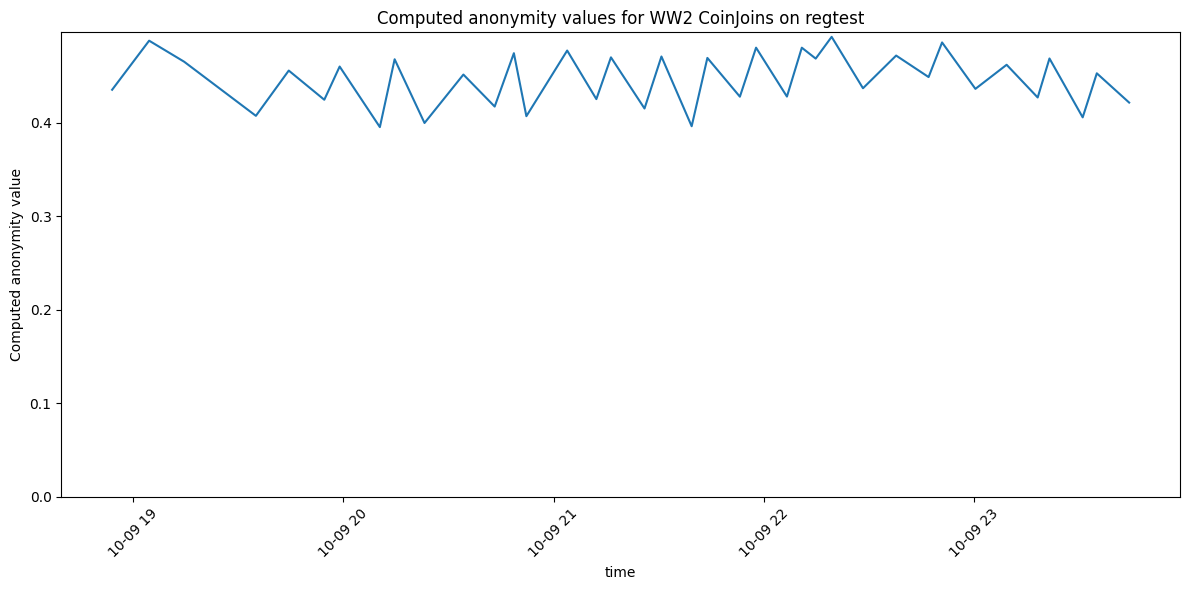

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from math import log2, factorial

print(next(iter(ww2_original_data.items()))[0].block_time)

def plot_anonymity_degradation(original_data, tag):
    # the log2(factorial(tx.output_count)) is used to normalize over the output count to compute sort of "percentage"
    # of the available "entropy"
    df_original = pd.DataFrame(
        [(transaction.block_time, count / log2(factorial(transaction.output_count))) for transaction, count in original_data.items()],
        columns=["block_time", "original_anonymity_score"],
    )

    
    # Ensure block_time is a datetime object
    df_original["block_time"] = pd.to_datetime(df_original["block_time"])
    df_original = df_original.sort_values(by="block_time")
    print(df_original)
    
    # Plot the data
    plt.figure(figsize=(12, 6))
    plt.plot(
        df_original["block_time"],
        df_original["original_anonymity_score"],
        label="Original computed anonymity value",
    )
    
    plt.xlabel("time")
    plt.ylabel("Computed anonymity value")
    plt.title(f"Computed anonymity values for {tag.split('_')[0].upper()} CoinJoins on regtest")
    plt.xticks(rotation=45)
    plt.ylim(ymin=0)
    plt.tight_layout()
    plt.savefig(f"/mnt/blocksci/anonymity_degradation_{tag}_regtest.png")
    plt.show()

plot_anonymity_degradation(ww2_original_data, "ww2_multiple_txes")
